In [1]:
import sys 
import os 
sys.path.insert(1, '..')
sys.path.insert(2, '../modules/')
import drms
from ruffus import *
import re
import pickle
import warnings
# from create_sxi_availability_db import WORKING_DIR
warnings.filterwarnings("ignore")
from modules import convert_datetime
from modules import query_the_data
import dataconfig
from modules import sxi_module
from modules import helio_reg_exp_module
from time import sleep
from random import randint
import sqlalchemy as sa
import pandas as pd

loaded libraries sxi module: 0:00:00.752886
loaded libraries sxi module: 0:00:00.000022


In [2]:
jsoc_email = dataconfig.NOTIFY_EMAIL_ADDR


In [3]:
def make_aia_jsoc_availability_query_string(time_ex_1, time_ex_2):

    time_str_1 = f'{time_ex_1:%Y-%m-%dT%H:%M:%S}'

    time_str_2 = f'{time_ex_2:%Y-%m-%dT%H:%M:%S}'

    query_str = f'aia.lev1_euv_12s[{time_str_1}Z-{time_str_2}Z]{{image}}'

    return(query_str)


def make_aia_availability_filename(jsoc_query_str):

    sub2 = re.sub(':', '_', jsoc_query_str)

    sub3 = re.sub('.lev1_euv_12s\[','_', sub2)

    sub4 = re.sub(']{image}', '', sub3)

    return(sub4)


def make_aia_fits_filename(date_time_instance,WL):

    this_file_time = f'{date_time_instance:%Y-%m-%dT%H_%M_%S_%f}'[:-4] # shave off the last 4 digits of the microseconds %f of the date_time string formatter

    sub = re.sub(':', '_', this_file_time)

    sub2 = re.sub('Z','z', sub)

    sub3 = re.sub('T','t', sub2)

    sub4 = re.sub('-', '_', sub3)

    this_filename = f'aia_lev1_{WL}a_{sub4}z_image_lev1.fits'

    return(this_filename)

In [4]:
client = drms.Client(email=jsoc_email)
keys = [
    "EXPTIME",
    "QUALITY",
    "T_OBS",
    "WAVELNTH",
    "R_SUN", 
    "RSUN_OBS", 
    "RSUN_REF",
    "DSUN_REF", 
    "DSUN_OBS",
    "CDELT1"
]

In [5]:
start_download_from = '2010-06-01T00:00:00'
end_download_at = '2010-06-06T00:00:00'

In [6]:

START_DATE_TIME = pd.Timestamp(start_download_from, tz = 'utc')

END_DATE_TIME = pd.Timestamp(end_download_at, tz = 'utc')

frequency = '4H'

datelist = pd.date_range(start = START_DATE_TIME , end = END_DATE_TIME, freq = frequency ).tolist()

this_query_list = [make_aia_jsoc_availability_query_string(previous,current) for previous,current in zip(datelist[:], datelist[1:])]


WORKING_DIR = dataconfig.DATA_DIR_AIA_AVAIL

DATA_PRODUCT_DIR = dataconfig.DATA_DIR_PRODUCTS

tw = lambda x: os.path.join(WORKING_DIR, x)

In [7]:
from random import shuffle

shuffle(this_query_list)

In [8]:
this_query_list

['aia.lev1_euv_12s[2010-06-04T00:00:00Z-2010-06-04T04:00:00Z]{image}',
 'aia.lev1_euv_12s[2010-06-01T12:00:00Z-2010-06-01T16:00:00Z]{image}',
 'aia.lev1_euv_12s[2010-06-04T04:00:00Z-2010-06-04T08:00:00Z]{image}',
 'aia.lev1_euv_12s[2010-06-01T04:00:00Z-2010-06-01T08:00:00Z]{image}',
 'aia.lev1_euv_12s[2010-06-02T00:00:00Z-2010-06-02T04:00:00Z]{image}',
 'aia.lev1_euv_12s[2010-06-01T20:00:00Z-2010-06-02T00:00:00Z]{image}',
 'aia.lev1_euv_12s[2010-06-05T16:00:00Z-2010-06-05T20:00:00Z]{image}',
 'aia.lev1_euv_12s[2010-06-03T00:00:00Z-2010-06-03T04:00:00Z]{image}',
 'aia.lev1_euv_12s[2010-06-03T12:00:00Z-2010-06-03T16:00:00Z]{image}',
 'aia.lev1_euv_12s[2010-06-05T08:00:00Z-2010-06-05T12:00:00Z]{image}',
 'aia.lev1_euv_12s[2010-06-03T04:00:00Z-2010-06-03T08:00:00Z]{image}',
 'aia.lev1_euv_12s[2010-06-01T08:00:00Z-2010-06-01T12:00:00Z]{image}',
 'aia.lev1_euv_12s[2010-06-05T04:00:00Z-2010-06-05T08:00:00Z]{image}',
 'aia.lev1_euv_12s[2010-06-02T12:00:00Z-2010-06-02T16:00:00Z]{image}',
 'aia.

In [9]:
records, filenames = client.query(this_query_list[0], key=keys, seg="image")

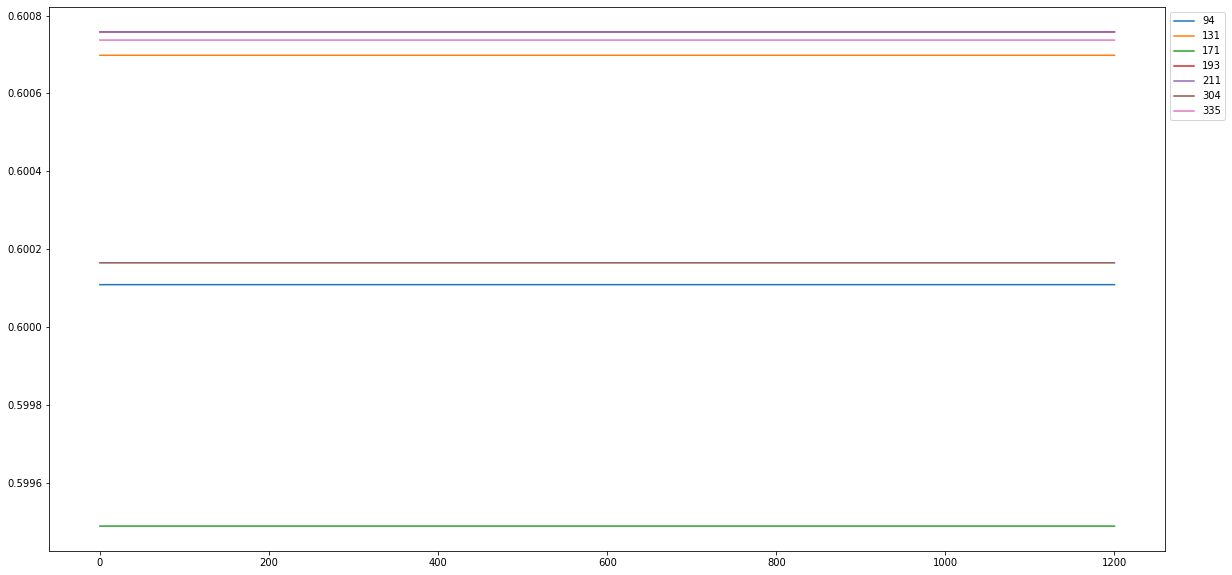

In [15]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111)

for wl, wl_group in records.groupby(['WAVELNTH']):

    x_axis = np.arange(0,len(wl_group))
    y_axis = wl_group.CDELT1
    ax.plot(x_axis, y_axis, label = wl)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
# ax.set_ylim(0,1)

# These records are inserted into the aia_availability.db SQLite database located in data_products directory


# Next SXI data inserted into the sxi_availability.db database. 
### Since, we don't know what data links exists, we will scrape 'https://www.ncei.noaa.gov/data/goes-solar-xray-imager/access/fits/goesXX/YYYY/MM/DD/'


In [2]:
WORKING_DIR = dataconfig.DATA_DIR_GOES_SXI
DATA_PRODUCT_DIR = dataconfig.DATA_DIR_PRODUCTS

tw = lambda x: os.path.join(WORKING_DIR, x)

from datetime import timedelta, date

instruments = ['goes13', 'goes14', 'goes15']

inst_dict = {'goes13': 'g13', 'goes14': 'g14', 'goes15': 'g15'}


#Set timelimits you want to download from
start_download_from = '2011-09-06T00:00:00'
end_download_at = '2011-09-07T00:00:00'


# start_download_from = '2014-12-01T00:00:00'
# end_download_at = '2015-01-01T23:59:59'

START_DATE_TIME = pd.Timestamp(start_download_from, tz = 'utc')

END_DATE_TIME = pd.Timestamp(end_download_at, tz = 'utc')


def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)


all_dates_list = []

for dt in daterange(START_DATE_TIME, END_DATE_TIME):
    # all_dates_list.append(dt.strftime("%Y%m%d"))
    all_dates_list.append(dt)

# Where from noaa FTP portal are you downloading from?

# ftp_prename = 'ftp://satdat.ngdc.noaa.gov/sxi/archive/fits'
# http_prename = 'https://satdat.ngdc.noaa.gov/sxi/archive/fits'

http_query_name = 'https://www.ncei.noaa.gov/data/goes-solar-xray-imager/access/fits/goes13/2011/09/06/'

ftp_prename = 'ftp://www.ncei.noaa.gov/data/goes-solar-xray-imager/access/fits'
http_prename = 'https://www.ncei.noaa.gov/data/goes-solar-xray-imager/access/fits'
# NOTE: we are interested in the ftp file that resembles:
#  ftp://satdat.ngdc.noaa.gov/sxi/archive/fits/goesXX/YYYY/MM/DD/*BA*.FTS

ftp_name_dict = []

for full_instrument_name in instruments:

    for this_date in all_dates_list:

        year, month, day = this_date.strftime('%Y'), this_date.strftime('%m'), this_date.strftime('%d')

        # specific_file_name = 'sci_gxrs-l2-irrad_{}_d{}_v0-0-0.nc'.format(inst_dict[full_instrument_name], specific_date_str)

        ftp_name = f'{ftp_prename}/{full_instrument_name}/{year}/{month}/{day}'

        http_name = f'{http_prename}/{full_instrument_name}/{year}/{month}/{day}'

        outfile_str = tw(f'{year}-{month}-{day}_{full_instrument_name}.availability')

        ftp_name_dict.append({'download_file': ftp_name, 'availability_file': http_name , 'out_name': outfile_str })

In [3]:
ftp_name_dict

[{'download_file': 'ftp://www.ncei.noaa.gov/data/goes-solar-xray-imager/access/fits/goes13/2011/09/06',
  'availability_file': 'https://www.ncei.noaa.gov/data/goes-solar-xray-imager/access/fits/goes13/2011/09/06',
  'out_name': '/mnt/e/ALEXIS_data/sxi_availability/2011-09-06_goes13.availability'},
 {'download_file': 'ftp://www.ncei.noaa.gov/data/goes-solar-xray-imager/access/fits/goes13/2011/09/07',
  'availability_file': 'https://www.ncei.noaa.gov/data/goes-solar-xray-imager/access/fits/goes13/2011/09/07',
  'out_name': '/mnt/e/ALEXIS_data/sxi_availability/2011-09-07_goes13.availability'},
 {'download_file': 'ftp://www.ncei.noaa.gov/data/goes-solar-xray-imager/access/fits/goes14/2011/09/06',
  'availability_file': 'https://www.ncei.noaa.gov/data/goes-solar-xray-imager/access/fits/goes14/2011/09/06',
  'out_name': '/mnt/e/ALEXIS_data/sxi_availability/2011-09-06_goes14.availability'},
 {'download_file': 'ftp://www.ncei.noaa.gov/data/goes-solar-xray-imager/access/fits/goes14/2011/09/07',

In [4]:
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'}

from bs4 import BeautifulSoup

from requests import get
http_query_name = ftp_name_dict[1]['availability_file']
print(http_query_name)

# http_query_name = 'https://www.ncei.noaa.gov/data/goes-solar-xray-imager/access/fits/goes13/2011/09/06/'

# outfile_name = queries['outname']

# print(outfile)

# download_str = f'wget -e robots=off --recursive --no-parent globs = True --directory-prefix {WORKING_DIR} --no-directories --verbose False {ftp_query_name}'

# os.system(download_str)

response = get(http_query_name, headers = headers)

https://www.ncei.noaa.gov/data/goes-solar-xray-imager/access/fits/goes13/2011/09/07


In [5]:
response

<Response [200]>

In [6]:
response.status_code

200

In [7]:
sxi_links = []

ftp_generic_path = ftp_name_dict[1]['availability_file']

print(ftp_generic_path)
if response.status_code == 200:
    html_soup = BeautifulSoup(response.content, 'html.parser')

    for link in html_soup.find_all('a'):

        file_name = str(link.get('href'))

        if file_name.startswith('SXI'):

            level= re.findall(r'(?<=\d{9}_)[A-Za-z0-9]{2}', file_name)[0]

            inst = re.findall(r'(?<=\d{9}_[A-Za-z0-9]{2}_)\d{2}', file_name)[0]

            date_time_str = re.findall(r'\d{8}_\d{9}', file_name )[0]

            date_time_obj = pd.to_datetime(date_time_str, format = '%Y%m%d_%H%M%S%f', utc = True)

            time_stamp = convert_datetime.convert_datetime_to_timestamp(date_time_obj)

            # year, month, day = date_time_obj.strftime('%Y'), date_time_obj.strftime('%m'), date_time_obj.strftime('%d')

            full_instrument_name = f'goes{inst}'

            # ftp_prename = 'ftp://satdat.ngdc.noaa.gov/sxi/archive/fits'

            url_path = f'{ftp_generic_path}/{file_name}'

            # print(ftp_query_name)
# 
            download_str = f'wget -e robots=off --recursive --no-parent globs = True --directory-prefix {WORKING_DIR} --no-directories --verbose False {url_path}'

            sxi_links.append({'download_string': download_str, 'time_stamp': time_stamp, 'data_level': level, 'file_name': file_name, 'instrument': full_instrument_name, 'url': url_path})

    available_data_df = pd.DataFrame(sxi_links)

https://www.ncei.noaa.gov/data/goes-solar-xray-imager/access/fits/goes13/2011/09/07


In [8]:
available_data_df

,download_string,time_stamp,data_level,file_name,instrument,url
0,wget -e robots=off --recursive --no-parent glo...,1.315354e+09,AB,SXI_20110907_000015123_AB_13.FTS,goes13,https://www.ncei.noaa.gov/data/goes-solar-xray...
1,wget -e robots=off --recursive --no-parent glo...,1.315354e+09,BA,SXI_20110907_000015123_BA_13.FTS,goes13,https://www.ncei.noaa.gov/data/goes-solar-xray...
2,wget -e robots=off --recursive --no-parent glo...,1.315354e+09,AB,SXI_20110907_000115159_AB_13.FTS,goes13,https://www.ncei.noaa.gov/data/goes-solar-xray...
3,wget -e robots=off --recursive --no-parent glo...,1.315354e+09,BA,SXI_20110907_000115159_BA_13.FTS,goes13,https://www.ncei.noaa.gov/data/goes-solar-xray...
4,wget -e robots=off --recursive --no-parent glo...,1.315354e+09,AB,SXI_20110907_000215156_AB_13.FTS,goes13,https://www.ncei.noaa.gov/data/goes-solar-xray...
...,...,...,...,...,...,...
3015,wget -e robots=off --recursive --no-parent glo...,1.315440e+09,AB,SXI_20110907_235600141_AB_13.FTS,goes13,https://www.ncei.noaa.gov/data/goes-solar-xray...
3016,wget -e robots=off --recursive --no-parent glo...,1.315440e+09,AB,SXI_20110907_235615147_AB_13.FTS,goes13,https://www.ncei.noaa.gov/data/goes-solar-xray...
3017,wget -e robots=off --recursive --no-parent glo...,1.315440e+09,AB,SXI_20110907_235715127_AB_13.FTS,goes13,https://www.ncei.noaa.gov/data/goes-solar-xray...
3018,wget -e robots=off --recursive --no-parent glo...,1.315440e+09,AB,SXI_20110907_235815143_AB_13.FTS,goes13,https://www.ncei.noaa.gov/data/goes-solar-xray...


In [9]:
pd.DataFrame(sxi_links).iloc[0].download_string

'wget -e robots=off --recursive --no-parent globs = True --directory-prefix /mnt/e/ALEXIS_data/sxi_availability --no-directories --verbose False https://www.ncei.noaa.gov/data/goes-solar-xray-imager/access/fits/goes13/2011/09/07/SXI_20110907_000015123_AB_13.FTS'

In [23]:
[re.search(r'https:\/\/www.ncei.noaa.gov\/data\/goes-solar-xray-imager\/access\/fits\/goes\d{2}\/\d{4}\/\d{2}\/\d{2}\/SXI_\d{8}_\d{9}_[A-B][A-B]_\d{2}.FTS', this_download_string).group(0) for this_download_string in available_data_df.download_string]


['https://www.ncei.noaa.gov/data/goes-solar-xray-imager/access/fits/goes13/2011/09/07/SXI_20110907_000015123_AB_13.FTS',
 'https://www.ncei.noaa.gov/data/goes-solar-xray-imager/access/fits/goes13/2011/09/07/SXI_20110907_000015123_BA_13.FTS',
 'https://www.ncei.noaa.gov/data/goes-solar-xray-imager/access/fits/goes13/2011/09/07/SXI_20110907_000115159_AB_13.FTS',
 'https://www.ncei.noaa.gov/data/goes-solar-xray-imager/access/fits/goes13/2011/09/07/SXI_20110907_000115159_BA_13.FTS',
 'https://www.ncei.noaa.gov/data/goes-solar-xray-imager/access/fits/goes13/2011/09/07/SXI_20110907_000215156_AB_13.FTS',
 'https://www.ncei.noaa.gov/data/goes-solar-xray-imager/access/fits/goes13/2011/09/07/SXI_20110907_000215156_BA_13.FTS',
 'https://www.ncei.noaa.gov/data/goes-solar-xray-imager/access/fits/goes13/2011/09/07/SXI_20110907_000300132_AB_13.FTS',
 'https://www.ncei.noaa.gov/data/goes-solar-xray-imager/access/fits/goes13/2011/09/07/SXI_20110907_000300132_BA_13.FTS',
 'https://www.ncei.noaa.gov/data

In [27]:
# import os 

# os.system(pd.DataFracme(sxi_links).iloc[0].download_string)

In [11]:
ftp_name_dict[1]['download_file']


'ftp://www.ncei.noaa.gov/data/goes-solar-xray-imager/access/fits/goes13/2011/09/07'

In [16]:
available_data_df.iloc[0].download_string

'wget -e robots=off --recursive --no-parent globs = True --directory-prefix /mnt/e/ALEXIS_data/sxi_availability --no-directories --verbose False https://www.ncei.noaa.gov/data/goes-solar-xray-imager/access/fits/goes13/2011/09/07/SXI_20110907_000015123_AB_13.FTS'

In [22]:
re.search(r'https:\/\/www.ncei.noaa.gov\/data\/goes-solar-xray-imager\/access\/fits\/goes\d{2}\/\d{4}\/\d{2}\/\d{2}\/SXI_\d{8}_\d{9}_[A-B][A-B]_\d{2}.FTS', available_data_df.iloc[0].download_string).group(0)

'https://www.ncei.noaa.gov/data/goes-solar-xray-imager/access/fits/goes13/2011/09/07/SXI_20110907_000015123_AB_13.FTS'